C:\Users\jorda\AppData\Local\Temp\ipykernel_23484\2930145562.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Gender', y='GC Count', data=df, size=10, edgecolor='black', palette={'Male': 'green', 'Female': 'purple'})


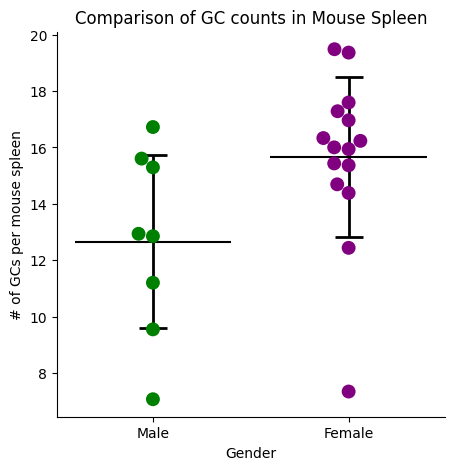

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming the data points are randomly generated for the purpose of this example
np.random.seed(0)
male_counts = np.random.normal(10, 3, size=8)
female_counts = np.random.normal(15, 3, size=15)

# Create a DataFrame to hold the data for Seaborn's swarmplot
data = {
    'Gender': ['Male'] * len(male_counts) + ['Female'] * len(female_counts),
    'GC Count': np.concatenate((male_counts, female_counts))
}

# Convert the dictionary to a Pandas DataFrame
import pandas as pd
df = pd.DataFrame(data) 

# Create the plot with Seaborn to have a swarmplot of points
plt.figure(figsize=(5, 5))
sns.swarmplot(x='Gender', y='GC Count', data=df, size=10, edgecolor='black', palette={'Male': 'green', 'Female': 'purple'})

# Calculate the mean and standard deviation for males and females
male_mean, male_std = np.mean(male_counts), np.std(male_counts)
female_mean, female_std = np.mean(female_counts), np.std(female_counts)

# Adding error bars for each group with mean and standard deviation
# Here 'capsize' adds the caps on the error bars
plt.errorbar(0, male_mean, yerr=male_std, fmt='none', color='black', capsize=10, elinewidth=2, capthick=2)
plt.errorbar(1, female_mean, yerr=female_std, fmt='none', color='black', capsize=10, elinewidth=2, capthick=2)

# Adding mean line
plt.hlines(male_mean, xmin=-0.4, xmax=0.4, colors='black', linestyles='solid')
plt.hlines(female_mean, xmin=0.6, xmax=1.4, colors='black', linestyles='solid')

# Setting the y-axis label
plt.ylabel('# of GCs per mouse spleen')

# Removing top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding a title
plt.title('Comparison of GC counts in Mouse Spleen')

plt.show()

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import os
import seaborn as sns

def plot_time_series(df, data_columns, scale='log10', title=None):
    # Define a dictionary of scale functions
    scale_functions = {'log10': np.log10, 'log2': np.log2, 'ln': np.log, 'normal': lambda x: x}
    scale_func = scale_functions.get(scale, np.log10)  # Default to log10 if scale is not recognized

    # Prepare the colormap
    unique_ids = df['ID'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_ids)))
    color_dict = dict(zip(unique_ids, colors))

    # Calculate the count of unique IDs for each 'Study Day'
    day_counts = df.groupby('Study.Day')['ID'].nunique()

    for i, column in enumerate(data_columns, 1):
        # If the data_column is ID or Study Day, skip it
        if column in ['ID', 'Study.Day']:
            continue
        plt.figure(figsize=(15, 5))

        # Plot individual points and lines
        for key, grp in df.groupby('ID'):
            color = color_dict[key]
            plt.scatter(grp['Study.Day'], scale_func(grp[column]), alpha=0.5, color=color)
            plt.plot(grp['Study.Day'], scale_func(grp[column]), alpha=0.3, color=color, linewidth=1)

        # Annotate the count of IDs for each 'Study Day'
        for day in day_counts.index:
            count = day_counts[day]
            plt.annotate(str(count), (day, 1), textcoords="offset points", xytext=(15,15), ha='center', fontsize=12)

        # Plot mean and std of the data
        mean_series = scale_func(df.groupby('Study.Day')[column].mean())
        std_series = scale_func(df.groupby('Study.Day')[column].std())
        std_series[std_series < 0] = 0

        plt.errorbar(mean_series.index, mean_series, yerr=std_series, fmt='o', color='black', zorder=3, label='Mean')
        # Connect the Mean points with a dashed line
        plt.plot(mean_series.index, mean_series, color='black', linestyle='dashed', zorder=2)

        if title is not None:
            plt.title(f'{title} {column}')
        plt.xlabel('Study Day')
        plt.ylabel(f'{scale}({column})')
        plt.ylim(bottom=0)
        plt.legend()
        plt.tight_layout()
        # Check if the destination folder exists, if not, create it
        if not os.path.exists(f'figures/Memphis/{title}/{scale}'):
            os.makedirs(f'figures/Memphis/{title}/{scale}')
        plt.savefig(f'figures/Memphis/{title}/{scale}/{column}.png')
        plt.show()
        plt.close()
        
# Memphis IDs match up to three patterns
# ID: (FXXXX). 4-digit ID Starting with F
# Study Day : (DXX, dXX, d XX, D XX, or just XX if prepended directly to FXXXX). Standardize  to 'DXX' after FXXXX.
# Contact ID : (CXX, CXXXX). Standardize to 'CXX' after FXXXX DXX.
def parse_id(id_str):
    # Find F pattern
    f_pattern = re.search(r'F\d{4}', id_str)
    if not f_pattern:
        return None  # Return None if F pattern is not found
    f_id = f_pattern.group()

    # Find Day pattern
    day_pattern = re.search(r'(D\d{2}|d \d{2}|D \d{2}|d\d{2}|\d{2}(?=F))', id_str)
    day_id = 'D' + (day_pattern.group().strip().replace(' ', '')[-2:] if day_pattern else '00')

    # Find C pattern
    c_pattern = re.search(r'C\d{2,4}', id_str)
    c_id = c_pattern.group() if c_pattern else ''

    # Combine the parts
    return f'{f_id} {day_id} {c_id}'.strip()


In [12]:
# Load Memphis data branches
Uninfected = pd.read_excel('data/Cohort data/Uninfected Cytokine Data.xlsx')
Uninfected = Uninfected[Uninfected['Cohort'] == 'Memphis'] # Filter Uninfected to the Memphis Cohort
Uninfected_IDs = Uninfected['ID'].unique() # Make a list of all Uninfected ID's

# Place Uninfected ID's from Nasal Wash into a seperate dataframe
Nasal_Wash = pd.read_excel('data/Cohort data/Memphis Flu Positive - Nasal Wash.xlsx')
Uninfected_Nasal_Wash = Nasal_Wash[Nasal_Wash['ID'].isin(Uninfected_IDs)]
Nasal_Wash = Nasal_Wash[~Nasal_Wash['ID'].isin(Uninfected_IDs)]

In [17]:
# Binning the Age data in the merged dataframe
age_bins = [0, 12, 18, 45, float('inf')]  # Age bins
age_labels = ['0-12', '13-18', '18-45', '45+']
nw_cytokines_merged['Age_Group'] = pd.cut(nw_cytokines_merged['Age'], bins=age_bins, labels=age_labels, right=False)

# Dropping non-cytokine columns for the analysis
cytokine_columns = nw_cytokines_merged.columns.difference(['ID', 'SJ MRN', 'Study Day', 'Season', 'Sample Type', 'Cohort', 'Age', 'Sex', 'Age_Group'])
age_cytokine_data = nw_cytokines_merged[cytokine_columns]

# Creating a directory for the age-based plots
age_plot_dir = '/mnt/data/analysis/age_specific_cytokines/'
os.makedirs(age_plot_dir, exist_ok=True)

# Iterating through cytokines to create plots
for cytokine in cytokine_columns:
    plt.figure(figsize=(12, 6))
    # Boxplot for age groups
    sns.boxplot(x='Age_Group', y=np.log10(age_cytokine_data[cytokine].replace(0, np.nan)), data=nw_cytokines_merged, color='lightblue', fliersize=0)
    # Strip plot for individual data points
    sns.stripplot(x='Age_Group', y=np.log10(age_cytokine_data[cytokine].replace(0, np.nan)), data=nw_cytokines_merged, size=3, jitter=True, palette='Set2')
    plt.title(f'{cytokine} Levels by Age Group')
    plt.ylabel(f'Log10({cytokine})')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Save the plot
    plt.savefig(age_plot_dir + f'{cytokine}_age_group.png')
    plt.close()